In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39155")
client

<Client: 'tcp://127.0.0.1:39155' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:39155' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pint_xarray
import xwavelet
import xrft
from scipy.interpolate import griddata

from oceanbench._src.geoprocessing.spatial import transform_360_to_180
from oceanbench._src.geoprocessing.spatial import latlon_deg2m
from oceanbench._src.metrics import power_spectrum as psdcalc

import matplotlib.pyplot as plt
%matplotlib inline

# Let's see what model outputs we have on the OSN cloud

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [5]:
for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""{params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("Not implemented.")
    print()

GIGATL parameters and their allowable args are:
region: ['1', '2']
datatype: ['surf', 'int']
season: ['fma', 'aso']

HYCOM25 parameters and their allowable args are:
region: ['1', '2', '3', '4', '5']
datatype: ['surface_hourly']
season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
region: ['1_GS', '2_GE', '3_MD']
datatype: ['surf', 'int', 'int_wvel', 'grid']
season: ['fma', 'aso', '']
grid: ['grid', '']

eNATL60 parameters and their allowable args are:
region: ['1', '2', '3']
datatype: ['surface_hourly', 'interior_daily']
season: ['fma', 'aso']

FESOM parameters and their allowable args are:
datatype: ['surf', 'int']
season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
region: ['1', '2', '3', '4']
datatype: ['surface_hourly', 'interior_daily', 'grid']
season: ['fma', 'aso', '']
grid: ['bathymetry', 'meshmask', '']

FIO-COM32 parameters and their allowable args are:
region: ['1', '2', '3', '4']
datatype: ['surface_hourly', 'surface_flux_hourly', 'i

# Let's use our favorite: eNATL60

In [28]:
ds = cat.eNATL60(region='2',datatype='surface_hourly', season='fma'
                ).to_dask().isel(time_counter=np.arange(0,2136,120))  # every 5 days
ds

<xarray.Dataset>
Dimensions:        (y: 735, x: 607, time_counter: 18)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(735, 607), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(735, 607), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(735, 607), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(735, 607), meta=np.ndarray>

In [29]:
da = ds.sossheig.reset_coords(drop=True).to_dataset(name='ssh')
da = da.rename({'time_counter':'time'})
da['ssh'].attrs["long_name"] = "Sea Surface Height"
da["ssh"].attrs["standard_name"] = "sea_surface_height"

da.coords['lat'] = ds.nav_lat.reset_coords(drop=True)
da.coords['lon'] = ds.nav_lon.reset_coords(drop=True)

da['lon'] = transform_360_to_180(da.lon)
da

<xarray.Dataset>
Dimensions:  (time: 18, y: 735, x: 607)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-27T00:30:00
    lat      (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    ssh      (time, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>

In [30]:
da = da.pint.quantify(
    {"ssh": "meter", 
     "lon": "degrees_east", 
     "lat": "degrees_north",
     "time": "nanoseconds"
    }
)
da

<xarray.Dataset>
Dimensions:  (time: 18, y: 735, x: 607)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-27T00:30:00
    lat      (y, x) float32 [degrees_N] dask.array<open_dataset-a8bc78b157f80...
    lon      (y, x) float32 [degrees_E] dask.array<sub, shape=(735, 607), dty...
Dimensions without coordinates: y, x
Data variables:
    ssh      (time, y, x) float32 [m] dask.array<getitem, shape=(18, 735, 607...

In [31]:
da_scaled = latlon_deg2m(da, mean=True)
da_scaled

<xarray.Dataset>
Dimensions:  (time: 18, y: 735, x: 607, lat: 735, lon: 607)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-27T00:30:00
  * lat      (lat) float64 0.0 32.39 64.77 ... 2.371e+04 2.374e+04 2.377e+04
  * lon      (lon) float64 0.0 27.8 55.6 83.39 ... 1.679e+04 1.682e+04 1.685e+04
Dimensions without coordinates: y, x
Data variables:
    ssh      (time, y, x) float32 [m] dask.array<getitem, shape=(18, 735, 607...

In [32]:
area = ds.e1t * ds.e2t

xT = np.cumsum(ds.e1u, axis=1)
yT = np.cumsum(ds.e2v, axis=0)
xT -= xT.isel(x=0)
yT -= yT.isel(y=0)
ny, nx = ds.tmask.shape
xT = (xT - xT.isel(x=nx//2)).values.flatten()
yT = (yT - yT.isel(y=ny//2)).values.flatten()
# xT = (xT - xT.isel(y=-1,x=0)).values.flatten()
# yT = (yT - yT.isel(y=0)).values.flatten()
dx = ds.e1t.min().values
dy = ds.e2t.min().values
xx, yy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]

In [33]:
ssh_interp = xr.ones_like(da.ssh).reset_coords(drop=True)
ssh_interp.coords['y'] = np.arange(0,ny*dy,dy)
ssh_interp.coords['x'] = np.arange(0,nx*dx,dx)
for tt in range(len(da.time)):
    ssh_interp[dict(time=tt)] = griddata((xT, yT), 
                                         (da.ssh.isel(time=tt)*area).values.flatten(),
                                         (xx, yy) 
                                        ).T
area_interp = griddata((xT, yT), 
                       area.values.flatten(),
                       (xx, yy) 
                      ).T
ssh_interp /= area_interp[np.newaxis]
ssh_interp

<xarray.DataArray 'ssh' (time: 18, y: 735, x: 607)>
dask.array<truediv, shape=(18, 735, 607), dtype=float64, chunksize=(1, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-27T00:30:00
  * y        (y) float64 0.0 1.391e+03 2.781e+03 ... 1.019e+06 1.021e+06
  * x        (x) float64 0.0 1.418e+03 2.836e+03 ... 8.577e+05 8.592e+05
Attributes:
    cell_methods:        time: mean (interval: 40 s)
    interval_operation:  40 s
    interval_write:      1 h
    long_name:           Sea Surface Height
    online_operation:    average
    standard_name:       sea_surface_height

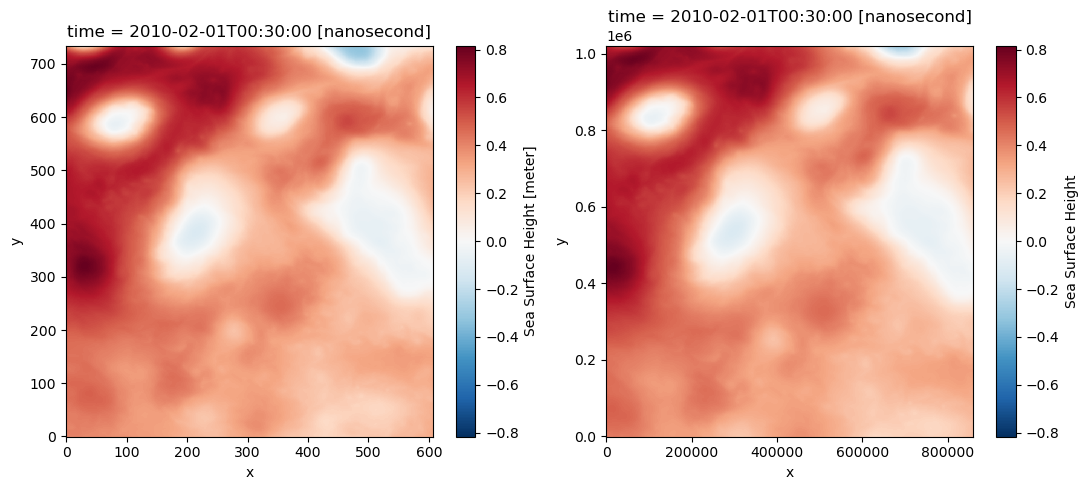

In [36]:
da_interp = ssh_interp.to_dataset(name='ssh')

fig, (ax1,ax2) = plt.subplots(figsize=(11,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
da_scaled.ssh.isel(time=0).plot(ax=ax1)
da_interp.ssh.isel(time=0).plot(ax=ax2)

## Compute the Fourier isotropic spectra

In [37]:
da_Fpsd_iso = psdcalc.psd_isotropic(da_interp, "ssh", ["y", "x"], **{'nfactor':8}
                                   ).mean('time').compute()
da_Fpsd_iso

<xarray.Dataset>
Dimensions:  (freq_r: 53)
Coordinates:
  * freq_r   (freq_r) float64 4.368e-06 1.035e-05 ... 0.0003453 0.000352
Data variables:
    ssh      (freq_r) float64 705.6 12.48 1.002 ... 8.047e-08 7.678e-08

## Compute the wavelet isotropic spectra

We set reference length scale as $50\,\text{km}$. The `scale` input argument, which sets the wavenumbers is non-dimensional and allows for flexibility in the wavenumber resolution, unlike Fast Fourier Transforms.

In [39]:
xo = 50e3  
s = xr.DataArray(np.linspace(da_Fpsd_iso.freq_r[-1].data**-1,
                             da_Fpsd_iso.freq_r[0].data**-1, 30
                            ) / xo,
                 dims=['scale'], 
                 coords={'scale':np.linspace(da_Fpsd_iso.freq_r[-1].data**-1,
                                             da_Fpsd_iso.freq_r[0].data**-1, 30
                                            ) / xo}
    )
sf = xr.DataArray(da_Fpsd_iso.freq_r.data**-1/xo, dims=['scale'], 
                  coords={'scale':da_Fpsd_iso.freq_r.data**-1/xo}
                 )[::2]
sh = xr.concat([s.where(s>1.).dropna('scale')[::-1],
                sf.where(sf<1.).dropna('scale')
               ], 'scale')
kwargs = {'xo':xo, 'scale':sh, 'ntheta':12}
da_Wpsd_iso = psdcalc.psd_isotropic(da_interp.chunk({'y':50,'x':50}), "ssh", ["y", "x"], 
                                    method='wavelet', **kwargs
                                   ).mean('time').compute()
da_Wpsd_iso

/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 1.92 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (angle: 6, scale: 48)
Coordinates:
  * angle    (angle) float64 0.0 0.5236 1.047 1.571 2.094 2.618
  * scale    (scale) float64 2.29e+05 2.212e+05 ... 2.953e+03 2.841e+03
Data variables:
    ssh      (angle, scale) float64 292.0 237.0 196.8 ... 6.091e-08 5.407e-08

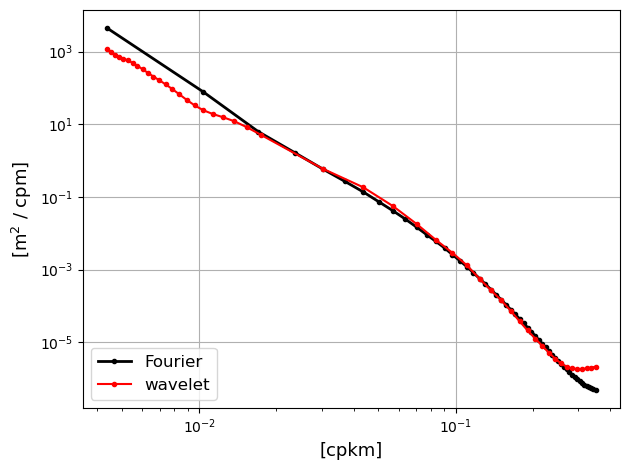

In [40]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
ax.plot(da_Fpsd_iso.freq_r*1e3, 
        da_Fpsd_iso.ssh * 2*np.pi, 
        'k.-', lw=2, label=r'Fourier')
ax.plot(da_Wpsd_iso.scale**-1*1e3, 
        (da_Wpsd_iso.ssh.sum('angle') 
         * np.pi/len(da_Wpsd_iso.angle) * 2), 
        'r.-', label=r"wavelet")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='lower left', fontsize=12)
ax.set_xlabel(r'[cpkm]', fontsize=13)
ax.set_ylabel(r'[m$^2$ / cpm]', fontsize=13);